In [1]:
import numpy as np # linear algebra 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv) 
import matplotlib.pyplot as plt 
from PIL import Image , ImageDraw 
from sklearn.preprocessing import * 
import time 
import ast 
import os 
import keras 
import tensorflow as tf 
from keras import models, layers 
from keras import Input 
from keras.models import Model, load_model 
from keras.preprocessing.image import ImageDataGenerator 
from keras import optimizers, initializers, regularizers, metrics 
from keras.callbacks import ModelCheckpoint, EarlyStopping 
from keras.layers import BatchNormalization, Conv2D, Activation , AveragePooling2D , Input ,Dropout 
from keras.layers import Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add, Flatten 
from keras.models import Sequential 
from keras.metrics import top_k_categorical_accuracy 
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping 
#from keras.applications import ResNet50, vgg19,mobilenet_v2,InceptionV3 , InceptionResNetV2,DenseNet169 
from tqdm import tqdm 
import cv2
from sklearn.model_selection import train_test_split 
from keras.models import load_model

In [2]:
import tensorflow as tf
print(tf.__version__)

import keras
print(keras.__version__)

2.5.0
2.5.0


In [3]:
# outputMode = 0 -> 모델 결과값 그대로 
# outputMode = 1 -> 결과값에 argmax 후  
def Fruit_Classifier(inputdata, outputMode = 0):
    # 0 = Front = [1,0,0], 1 = Back = [0,1,0], 2 = Side = = [0,0,1]
    direction_output = direction_model.predict(inputdata)
    Y_direction_predict = []
    for a in direction_output:
        Y_direction_predict.append(np.argmax(a))
    side_list = []
    side_number = []
    front_list = []
    front_number = []
    back_list = []
    back_number = []
    
    for i, b in enumerate(Y_direction_predict):
        if b == 0 :
            front_list.append(inputdata[i].tolist())
            front_number.append(i)
        elif b == 1:
            back_list.append(inputdata[i].tolist())
            back_number.append(i)
        else:
            side_list.append(inputdata[i].tolist())
            side_number.append(i)
    side_list = np.array(side_list)  
    front_list = np.array(front_list) 
    back_list = np.array(back_list) 
    front_output = []
    back_output = []
    side_output = []
    
    # Bad = 0 = [1,0], Normal = 1 = [0,1]
    if len(front_list) > 0:
        _front_output = Front_model.predict(front_list)
        del front_list
        if outputMode == 0:
            front_output.append(_front_output.tolist())
        else:
            for i in _front_output:
                front_output.append(np.argmax(i))
    if len(back_list) > 0:
        _back_output = Back_model.predict(back_list)
        del back_list
        if outputMode == 0: 
            back_output.append(_back_output.tolist())
        else:
            for i in _back_output:
                back_output.append(np.argmax(i))
    if len(side_list) > 0:
        _side_output = Side_model.predict(side_list) 
        del side_list
        if outputMode == 0:
            side_output.append(_side_output.tolist())
        else:
            for i in _side_output:
                side_output.append(np.argmax(i))
    return Y_direction_predict, front_number, front_output, back_number, back_output, side_number, side_output

# 확률값 반환 함수
def function1(list1, list2):
    count = 0
    for i, j in zip(list1, list2):
        if i == j:
            count += 1
    return count / len(list1)


#  확률값 반환 + 리스트 비교 시 값이 다른 곳의 위치 반환
def function2(list1, list2):
    #if list1 != list2:
    #  return 
    count = 0
    othervalue_list = []
    for i, list_set in enumerate(zip(list1, list2)):
        if list_set[0] == list_set[1]:
            count += 1
        else:
            othervalue_list.append(i)
    output_per = count / len(list1)
    return output_per, othervalue_list

# 방향 구별 모델에서 다른 결과값의 리스트 제거
def del_list(othervalue_list, del_list):
    for i in othervalue_list:
        del del_list[i]

#결과값 정렬 알고리즘
def output_sorting(front_number, front_output, back_number, back_output, side_number, side_output):
    list_output = []
    list_num = []
    for i in front_output:
        list_output.append(i)
    for i in back_output:
        list_output.append(i)
    for i in side_output:
        list_output.append(i)
        
    for i in front_number:
        list_num.append(i)
    for i in back_number:
        list_num.append(i)
    for i in side_number:
        list_num.append(i)
        
    length = len(list_num)
    for i in range(length):
        length2 = length - i
        for j in range(length2):
            if list_num[i] > list_num[j + i]:
                num = list_num[i]
                output = list_output[i]
                list_num[i] = list_num[j + i]
                list_output[i] = list_output [ j + i]
                list_num[j + i] = num
                list_output [ j + i] = output
    return list_num, list_output

In [4]:
path = 'C:/Users/sdf80/Desktop/ValidationData/'

filename = os.listdir(path)
datalist = pd.DataFrame(data=[], columns=['label','img'])

label = []
img = []

for file in tqdm(filename):
    split_label = file.split('.')
    label.append(split_label[0]+ split_label[1])
    img.append(file)
    
datalist['label'] = label
datalist['img'] = img 

def preprocessing(path) :
    X = []
    y_FullName = []
    y_StateNum = []
    y_DirectionNum = []
    class_label = []
    class_num = 6
    
    for num in tqdm(range(len(datalist['img']))) :
        img = cv2.imread(path+datalist['img'][num])
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(160,160))
        
        if datalist['label'][num] == 'SideBad': 
            X.append(img) 
            y_FullName.append('SideBad') 
            y_StateNum.append(0)
            y_DirectionNum.append(2)
        elif datalist['label'][num] == 'SideNormal':
            X.append(img) 
            y_FullName.append('SideNormal')
            y_StateNum.append(1)
            y_DirectionNum.append(2)
        elif datalist['label'][num] == 'FrontBad': 
            X.append(img) 
            y_FullName.append('FrontBad')
            y_StateNum.append(0)
            y_DirectionNum.append(0)
        elif datalist['label'][num] == 'FrontNormal': 
            X.append(img) 
            y_FullName.append('FrontNormal')
            y_StateNum.append(1)
            y_DirectionNum.append(0)
        elif datalist['label'][num] == 'BackBad': 
            X.append(img) 
            y_FullName.append('BackBad')
            y_StateNum.append(0)
            y_DirectionNum.append(1)
        elif datalist['label'][num] == 'BackNormal': 
            X.append(img) 
            y_FullName.append('BackNormal')
            y_StateNum.append(1)
            y_DirectionNum.append(1)
        else:
            print('알림')
            
    X = np.array(X) 
    y_FullName = np.array(y_FullName) 
    y_StateNum = np.array(y_StateNum) 
    y_DirectionNum = np.array(y_DirectionNum) 
    
    
    #y_FullName = np.array([[i] for i in y_FullName]) 
    #y_StateNum = np.array([[i] for i in y_StateNum]) 
    #y_DirectionNum = np.array([[i] for i in y_DirectionNum]) 
    
    #enc = OneHotEncoder(categories='auto') 
    #enc.fit(y_StateNum) 
    #tmpy = enc.transform(y_StateNum).toarray() 

    #del Y #RAM메모리 절약을 위해 사용하지 않는 변수 삭제
    return X, y_FullName, y_StateNum ,y_DirectionNum, class_label , class_num


X, y_FullName, y_StateNum, y_DirectionNum, class_label, class_num = preprocessing(path)
X = X/ 255
#파일이름이 담긴 배열 

print(X.shape, y_FullName.shape)

FileNotFoundError: [WinError 3] 지정된 경로를 찾을 수 없습니다: 'C:/Users/sdf80/Desktop/ValidationData/'

# MobileNet Weights Setting

In [4]:
model_path = 'C:/Users/sdf80/Desktop/Colab_Model/'

direction_name=os.path.join(model_path, 'Colab_Direction_Modified_MobileNet_Weight_Test.h5')
side_name=os.path.join(model_path, 'Colab_Side_Modified_MobileNet_Weight.h5')
front_name=os.path.join(model_path, 'Colab_Front_Modified_MobileNet_Weight.h5')
back_name=os.path.join(model_path, 'Colab_Back_Modified_MobileNet_Weight.h5')

In [6]:
def MobileNetConv(data, channel):
    shortcut = data
    x = tf.keras.layers.DepthwiseConv2D(
    (3,3), strides=(1, 1), padding='SAME', depth_multiplier=1,
    data_format=None, activation=None, use_bias=True,
    depthwise_initializer='glorot_uniform', bias_initializer='zeros',
    depthwise_regularizer=None, bias_regularizer=None, activity_regularizer=None,
    depthwise_constraint=None, bias_constraint=None, )(data) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Add()([x, shortcut])
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(channel, (1,1), activation='relu', padding='SAME')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    return x

def Model_Structure():
    input = Input(shape=(160,160,3))
    x = MobileNetConv(input, 32)
    x = MobileNetConv(x, 64)
    x = MobileNetConv(x, 128)
    x = MobileNetConv(x, 256)
    x = MobileNetConv(x, 512)
    x = MobileNetConv(x, 1024)
    x = Flatten()(x)
    x = Dense(1000, activation='relu')(x)
    x = Dense(2, activation='sigmoid')(x)
    Modified_MobileNet_Model = Model(input, x)  
    Modified_MobileNet_Model.compile(optimizer='adam',   #RMSprop(lr=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy'])
    return Modified_MobileNet_Model


def Direction_Model_Structure():
    input = Input(shape=(160,160,3))
    x = MobileNetConv(input, 32)
    x = MobileNetConv(x, 64)
    x = MobileNetConv(x, 128)
    x = MobileNetConv(x, 256)
    x = MobileNetConv(x, 512)
    x = MobileNetConv(x, 1024)
    x = Flatten()(x)
    x = Dense(1000, activation='relu')(x)
    x = Dense(3, activation='softmax')(x)
    Modified_MobileNet_Model = Model(input, x)  
    Modified_MobileNet_Model.compile(optimizer='adam',   #RMSprop(lr=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy'])
    return Modified_MobileNet_Model


In [22]:
Direction_Modified_MobileNet_Model = Direction_Model_Structure()
Front_Modified_MobileNet_Model = Model_Structure()
Back_Modified_MobileNet_Model = Model_Structure()
Side_Modified_MobileNet_Model = Model_Structure()
Direction_Modified_MobileNet_Model.summary()

The following Variables were used a Lambda layer's call (tf.compat.v1.nn.depthwise_conv2d_48), but
are not present in its tracked objects:
  <tf.Variable 'depthwise_conv2d_48/depthwise_kernel:0' shape=(3, 3, 3, 1) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_48), but
are not present in its tracked objects:
  <tf.Variable 'depthwise_conv2d_48/bias:0' shape=(3,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.compat.v1.nn.depthwise_conv2d_49), but
are not present in its tracked objects:
  <tf.Variable 'depthwise_conv2d_49/depthwise_k

The following Variables were used a Lambda layer's call (tf.compat.v1.nn.depthwise_conv2d_58), but
are not present in its tracked objects:
  <tf.Variable 'depthwise_conv2d_58/depthwise_kernel:0' shape=(3, 3, 256, 1) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_58), but
are not present in its tracked objects:
  <tf.Variable 'depthwise_conv2d_58/bias:0' shape=(256,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.compat.v1.nn.depthwise_conv2d_59), but
are not present in its tracked objects:
  <tf.Variable 'depthwise_conv2d_59/depthwi

The following Variables were used a Lambda layer's call (tf.compat.v1.nn.depthwise_conv2d_68), but
are not present in its tracked objects:
  <tf.Variable 'depthwise_conv2d_68/depthwise_kernel:0' shape=(3, 3, 64, 1) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_68), but
are not present in its tracked objects:
  <tf.Variable 'depthwise_conv2d_68/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.compat.v1.nn.depthwise_conv2d_69), but
are not present in its tracked objects:
  <tf.Variable 'depthwise_conv2d_69/depthwise

In [28]:
Direction_Modified_MobileNet_Model.load_weights(direction_name)
Front_Modified_MobileNet_Model.load_weights(front_name)
Back_Modified_MobileNet_Model.load_weights(side_name)
Side_Modified_MobileNet_Model.load_weights(side_name)

In [29]:
output = Direction_Modified_MobileNet_Model.predict(X)
print(np.argmax(output, axis = 1))
print(y_DirectionNum)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [4]:
model_path = 'C:/Users/sdf80/Desktop/Colab_Model/Model/'

In [17]:
direction_name=os.path.join(model_path, 'Colab_Direction_VGG19.h5')
side_name=os.path.join(model_path, 'Colab_Side_VGG19.h5')
front_name=os.path.join(model_path, 'Colab_Front_VGG19.h5')
back_name=os.path.join(model_path, 'Colab_Back_VGG19.h5')

In [21]:
direction_name=os.path.join(model_path, 'Colab_Direction_ResNet50.h5')
side_name=os.path.join(model_path, 'Colab_Side_ResNet50.h5')
front_name=os.path.join(model_path, 'Colab_Front_ResNet50.h5')
back_name=os.path.join(model_path, 'Colab_Back_ResNet50.h5')

In [12]:
direction_name=os.path.join(model_path, 'Colab_Direction_Inception.h5')
side_name=os.path.join(model_path, 'Colab_Side_Inception.h5')
front_name=os.path.join(model_path, 'Colab_Front_Inception.h5')
back_name=os.path.join(model_path, 'Colab_Back_Inception.h5')

In [17]:
direction_name=os.path.join(model_path, 'Colab_Direction_Modified_MobileNet.h5')
side_name=os.path.join(model_path, 'Colab_Side_Modified_MobileNet.h5')
front_name=os.path.join(model_path, 'Colab_Front_Modified_MobileNet_v2.h5')
back_name=os.path.join(model_path, 'Colab_Back_Modified_MobileNet.h5')

In [18]:
direction_model = models.load_model(direction_name)
Side_model = models.load_model(side_name)
Front_model = models.load_model(front_name)
Back_model = models.load_model(back_name)

In [19]:
y_direction_predict, front_number, front_output, back_number, back_output, side_number, side_output = Fruit_Classifier(X, 1)

In [16]:
len(y_direction_predict)

600

In [18]:
print('front_number: ', front_number)
print('front_output: ', front_output)
print('----------------------------------------------------------------')
print('back_number: ', back_number)
print('back_output: ', back_output)
print('----------------------------------------------------------------')
print('side_number: ', side_number)
print('side_output: ', side_output)
print('----------------------------------------------------------------')

front_number:  [200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 279, 280, 283, 284, 285, 286, 287, 288, 290, 291, 292, 293, 295, 296, 298, 299, 300, 301, 302, 303, 304, 305, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 430]
front_output:  [0, 0, 0, 0, 0, 0, 

In [17]:
# 하나만 넣으면 오류뜸.
#state_output = Front_model.predict(X[1])

In [12]:
list_num, list_output = output_sorting(front_number, front_output, back_number, back_output, side_number, side_output)

In [13]:
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# InceptionV3

Confusion matrix, without normalization
[[279  21]
 [ 22 278]]


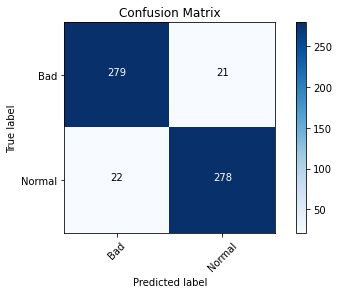

In [16]:
cm = confusion_matrix(y_true=y_StateNum, y_pred=list_output)
plot_confusion_matrix(cm=cm, classes=['Bad','Normal'], title='Confusion Matrix')

# ResNet50

Confusion matrix, without normalization
[[270  30]
 [ 28 272]]


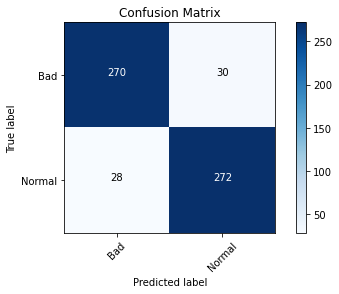

In [25]:
cm = confusion_matrix(y_true=y_StateNum, y_pred=list_output)
plot_confusion_matrix(cm=cm, classes=['Bad','Normal'], title='Confusion Matrix')

# VGG19

Confusion matrix, without normalization
[[289  11]
 [116 184]]


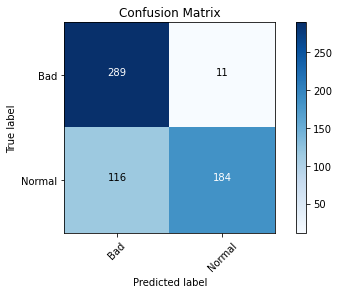

In [37]:
cm = confusion_matrix(y_true=y_StateNum, y_pred=list_output)
plot_confusion_matrix(cm=cm, classes=['Bad','Normal'], title='Confusion Matrix')

Confusion matrix, without normalization
[[289  11]
 [116 184]]


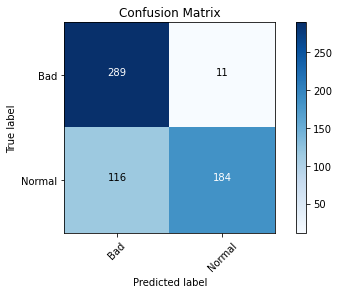

In [21]:
cm = confusion_matrix(y_true=y_StateNum, y_pred=list_output)
plot_confusion_matrix(cm=cm, classes=['Bad','Normal'], title='Confusion Matrix')

# Modified MobileNet

Confusion matrix, without normalization
[[293   7]
 [106 194]]


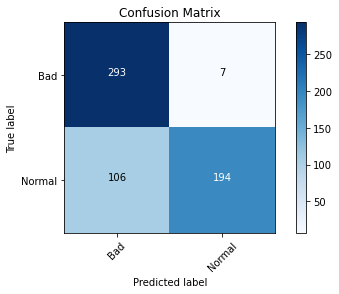

In [11]:
cm = confusion_matrix(y_true=y_StateNum, y_pred=list_output)
plot_confusion_matrix(cm=cm, classes=['Bad','Normal'], title='Confusion Matrix')

Confusion matrix, without normalization
[[283  17]
 [ 60 240]]


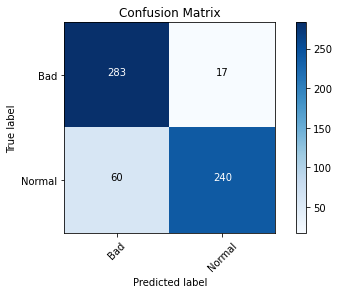

In [31]:
cm = confusion_matrix(y_true=y_StateNum, y_pred=list_output)
plot_confusion_matrix(cm=cm, classes=['Bad','Normal'], title='Confusion Matrix')

Confusion matrix, without normalization
[[283  17]
 [ 60 240]]


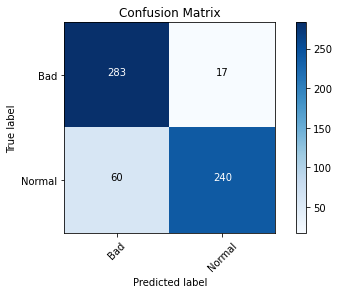

In [20]:
cm = confusion_matrix(y_true=y_StateNum, y_pred=list_output)
plot_confusion_matrix(cm=cm, classes=['Bad','Normal'], title='Confusion Matrix')